In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from networkx.algorithms import community
import seaborn as sns
import networkx as nx
from nltk.corpus import words
import nltk
from time import time
import pickle

nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\ritvik\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [4]:
books = ['book%s.txt'%i for i in range(1,8)]

full_text = ''
for book in books:
    try:
        full_text += open(book, 'r').read()
    except:
        full_text += open(book, 'r', encoding='UTF-8').read()

text = full_text.replace('\n', '')
text = [p.strip().translate(str.maketrans('', '', string.punctuation)) for p in text.split(' ')]

In [5]:
COMMON_PRONOUNS = ['He', 'She', 'It', 'The', 'A', 'I', 'They', 'Mr.', 'Mr', 'Ms.', 'Ms', 'Mrs.' ,'Mrs', 'Im', 
                   'And', 'There', 'But', 'Mrs', 'Then', 'You', 'Aunt', 'Uncle', 'Professor', 'Madam',
                   'At', 'As', 'His', 'When', 'What', 'Ill', 'If', 'This', 'In', 'All', 'Its', 'Id', 'So', 'How', 'No', 
                   'One', 'Now', 'For', 'On', 'After', 'Well', 'Not', 'Every', 'Even', 'Everyone', 'With', 'Where', 'We', 
                   'Their', 'Ive', 'My', 'Hes', 'To', 'Or', 'Yes', 'Why', 'Shes', 'Youre', 'Because', 'Dont', 'By', 'Of',
                   'Do', 'Only', 'Did', 'Who', 'Theres', 'What', 'Hed', 'Shed', 'Miss', 'Madame']
COMMON_PRONOUNS = [w.upper() for w in COMMON_PRONOUNS]
EXCEPTIONS = [w.upper() for w in ['Harry']]
TO_REMOVE = ['Potter', 'Black', 'Lord', 'Death', 'Sir', 'Gryffindor', 'Ravenclaw', 'Hollow', 
             'Christmas', 'Mum', 'Master', 'Sorry', 'Hogsmeade', 'Albus', 'Dad', 'Nearly', 'Magic', 
             'Slytherin', 'Hogwarts', 'Quidditch', 'Listen', 'Dark', 'Weasley', 'Malfoy', 'Peter', 
             'Muggle', 'Riddle', 'Muggles', 'Diggory']

In [6]:
all_characters = open('hp_characters.txt', 'r').read()
all_characters = all_characters.replace("'", '').replace("[", '').replace("]", '').split(',')
all_characters = [c.strip() for c in all_characters]

In [ ]:
all_characters = []

for sent in nltk.sent_tokenize(full_text):
    for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
        if type(chunk) == nltk.tree.Tree and chunk.label() == 'PERSON':
            all_characters.append(chunk[0][0])

In [7]:
counts = dict()
for c in all_characters:
    if c in counts:
        counts[c] += 1
    else:
        counts[c] = 1
tot_counts = sum(counts.values())
counts = {c: val/tot_counts for c,val in counts.items()}

potential_characters = [name for name,c in sorted(counts.items(), key=lambda x: -x[1]) if (name.upper() not in COMMON_PRONOUNS) and (name not in TO_REMOVE)]
duplicates = []

for c in [p for p in potential_characters if p[-1] == 's']:
    if c[:-1] in potential_characters:
        duplicates.append(c)
potential_characters = np.array([p for p in potential_characters if p not in duplicates])[:50]

In [8]:
potential_characters

array(['Harry', 'Ron', 'Hermione', 'Dumbledore', 'Snape', 'Hagrid',
       'Sirius', 'Voldemort', 'George', 'Ginny', 'Fred', 'Lupin',
       'Neville', 'Moody', 'Dobby', 'Dudley', 'Percy', 'Fudge',
       'Slughorn', 'Bill', 'Umbridge', 'Luna', 'Cedric', 'Draco', 'Fleur',
       'Goyle', 'Filch', 'Kreacher', 'Tonks', 'James', 'Lockhart',
       'Hedwig', 'Cho', 'Wood', 'Krum', 'Rita', 'Wormtail', 'Bagman',
       'Karkaroff', 'Lucius', 'Arthur', 'Don', 'Crabbe', 'Vernon', 'Tom',
       'Seamus', 'Charlie', 'Mundungus', 'Parvati', 'Griphook'],
      dtype='<U15')

In [9]:
char_to_alignment = {
    'Harry': 1, 'Ron': 1, 'Hermione': 1, 'Dumbledore': 1, 'Snape': 0, 
    'Hagrid': 1, 'Sirius': 1, 'Voldemort': -1, 'George': 1, 'Ginny': 1, 
    'Fred': 1, 'Lupin': 1, 'Neville': 1, 'Moody': 1, 'Dobby': 1, 
    'Dudley': 0, 'Percy': 1, 'Fudge': 0, 'Slughorn': 0, 'Bill': 1, 
    'Umbridge': -1, 'Luna': 1, 'Cedric': 1, 'Draco': -1, 'Fleur': 1,
    'Goyle': -1, 'Filch': 0, 'Kreacher': 0, 'Tonks': 1, 'James': 1, 
    'Lockhart': 1, 'Hedwig': 1, 'Cho': 1, 'Wood': 1, 'Krum': 0, 
    'Rita': 0, 'Wormtail': -1, 'Bagman': 0, 'Karkaroff': -1, 'Lucius': -1, 
    'Arthur': 1, 'Don': 0, 'Crabbe': -1, 'Vernon': 0, 'Tom': -1,
    'Seamus': 1, 'Charlie': 1, 'Mundungus': 0, 'Parvati': 1, 'Griphook': 0
}

In [10]:
tot_alignment = {a: len([v for k,v in char_to_alignment.items() if v == a]) for a in [-1,0,1]}

In [11]:
with open('AdjacencyMatrices/alignment.txt', 'a') as f:
    for k,v in char_to_alignment.items():
        line = str(k) + ' ' + str(v) + '\n'
        f.write(line)

In [ ]:
TOT_WORDS = len(text)
NUM_CHARS = len(potential_characters)

NUM_SECTIONS = 25
STEP_SIZE = TOT_WORDS // NUM_SECTIONS

THRESH_DIST = 10

#stores the average closest distances
inclusion_matrix = np.zeros((NUM_CHARS,NUM_CHARS, NUM_SECTIONS))

#stores the counts from the most recent timestamp
curr_counts = np.zeros((NUM_CHARS, NUM_CHARS))

#number of occurences at each time step for each character
num_occs = {}

for i in range(NUM_SECTIONS):
    num_occs[i] = {}
    start = time()
    print(i)
    curr_text = text[STEP_SIZE*i:STEP_SIZE*(i+1)]
    for idx1,c1 in enumerate(potential_characters):
        c1_inds = [idx for idx,item in enumerate(curr_text) if item.upper() == c1.upper()]
        num_occs[i][c1] = len(c1_inds)
        if len(c1_inds) == 0:
            continue
        for idx2,c2 in enumerate(potential_characters):
            c2_inds = [idx for idx,item in enumerate(curr_text) if item.upper() == c2.upper()]
            if len(c2_inds) == 0:
                continue
            counts = [min([abs(i1 - i2) for i2 in c2_inds]) < THRESH_DIST for i1 in c1_inds]
            
            if i > 0:
                dist = (inclusion_matrix[idx1,idx2,i-1]*curr_counts[idx1,idx2] + sum(counts)) / (curr_counts[idx1,idx2] + len(counts))
            else:
                dist = np.mean(counts)
                
            curr_counts[idx1,idx2] = len(counts)
            inclusion_matrix[idx1,idx2,i] = dist
    print(time() - start)

In [29]:
cumul_occs = {c: 0 for c in potential_characters}

for t in range(25):
    with open('AdjacencyMatrices/num_occs_%s.txt'%(t), 'a') as f:
        for k in potential_characters:
            v = num_occs[t][k]
            cumul_occs[k] += v
            line = str(k) + ' ' + str(cumul_occs[k]) + '\n'
            f.write(line)

NameError: name 'num_occs' is not defined

In [12]:
def rolling_avg(s, k):
    return np.concatenate([s[:k-1], [np.mean(s[i-k+1:i+1]) for i in range(k-1,len(s))]])

In [13]:
for i in range(25):
    np.fill_diagonal(inclusion_matrix[:,:,i], 0)

NameError: name 'inclusion_matrix' is not defined

In [26]:
for i in range(50):
    for j in range(50):
        inclusion_matrix[i,j,:] = rolling_avg(inclusion_matrix[i,j,:], 5)

In [27]:
pickle.dump(inclusion_matrix, open("inclusion_matrix.p", 'wb'))

In [14]:
inclusion_matrix = pickle.load(open('inclusion_matrix.p', 'rb'))

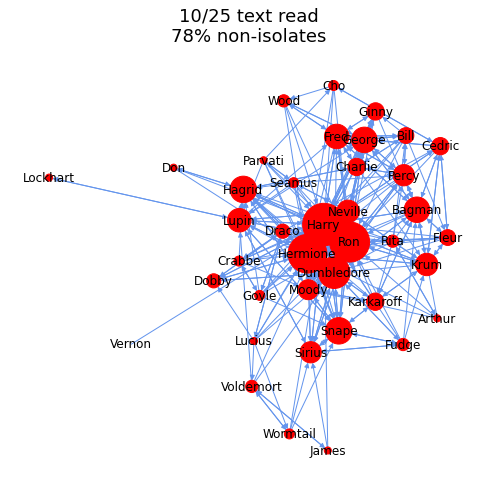

In [15]:
PCT_THRESH = 0.01
plt.figure(figsize=(7,7))
curr_subplot = 1

for i in range(9,10):
    
    #plt.subplot(6,4,i+1)
    plt.subplot(1,1,1)
    m = inclusion_matrix[:,:,i].copy()
    np.fill_diagonal(m, 0)
    m[m < PCT_THRESH] = 0
    m[m >= PCT_THRESH] = 1
    include = (np.sum(m, axis=1) > 0) & (np.sum(m, axis=0) > 0)
    m = m[include, :][:, include]
    chars = potential_characters[include]
    
    G = nx.from_numpy_matrix(m, create_using=nx.DiGraph)
    G = nx.relabel_nodes(G, {i:p for i,p in enumerate(chars)})
    nx.draw(G, with_labels=True, node_color='r', edge_color='cornflowerblue', node_size=np.sum(m, axis=0)*50, pos=nx.fruchterman_reingold_layout(G))
    plt.title('%s/%s text read\n%s%% non-isolates'%(i+1,inclusion_matrix.shape[-1],int(100*round(len(chars) / len(potential_characters),2))), fontsize=18)
    
    curr_subplot += 1

plt.tight_layout()
plt.savefig('hp_communities_high_centrality.png')

# Centralities

In [16]:
PCT_THRESH = 0.1

time_to_G = dict()

for i in range(inclusion_matrix.shape[-1]):
    
    m = inclusion_matrix[:,:,i].copy()
    np.fill_diagonal(m, 0)
    m[m < PCT_THRESH] = 0
    m[m >= PCT_THRESH] = 1
    
    G = nx.from_numpy_matrix(m, create_using=nx.DiGraph)
    G = nx.relabel_nodes(G, {i:p for i,p in enumerate(potential_characters)})
    time_to_G[i] = G

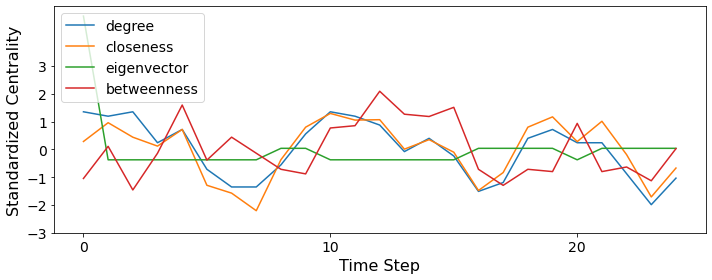

In [17]:
degree_centralities = [np.mean([v for v in nx.degree_centrality(g).values()])/2 for t,g in time_to_G.items()]
closeness_centralities = [np.mean([v for v in nx.closeness_centrality(g).values()]) for t,g in time_to_G.items()]
eigenvector_centralities = [np.mean([v for v in nx.eigenvector_centrality(g).values()]) for t,g in time_to_G.items()]
betweenness_centralities = [np.mean([v for v in nx.betweenness_centrality(g).values()]) for t,g in time_to_G.items()]

centralities = np.zeros((25,4))
centralities[:,0] = degree_centralities
centralities[:,1] = closeness_centralities
centralities[:,2] = eigenvector_centralities
centralities[:,3] = betweenness_centralities

centralities = (centralities - centralities.mean(axis=0)) / centralities.std(axis=0)

plt.figure(figsize=(10,4))
ranks = np.argsort(centralities, axis=0)

plt.plot(centralities)
plt.legend(['degree', 'closeness', 'eigenvector', 'betweenness'], fontsize=14, loc=2)
plt.xlabel('Time Step', fontsize=16)
plt.xticks(np.arange(0,25,10), fontsize=14)
plt.ylabel('Standardized Centrality', fontsize=16)
plt.yticks(np.arange(-3,4), fontsize=14)

plt.tight_layout()

plt.savefig('centrality_agreement.png')

# Reciprocity

In [18]:
def normalize(s):
    return (s - s.mean()) / s.std()

In [19]:
rec_mtx = np.empty((100,100))
rec_mtx[:] = np.nan
LIM = 0.05

for i1,c1 in enumerate(potential_characters):
    for i2,c2 in enumerate(potential_characters):
        if i1 < i2 and (np.mean(inclusion_matrix[i1,i2,:] == 0) < LIM or np.mean(inclusion_matrix[i2,i1,:] == 0) < LIM):
            c1_c2_ts = normalize(inclusion_matrix[i1,i2,:])
            c2_c1_ts = normalize(inclusion_matrix[i2,i1,:])
        
            rec_mtx[i1,i2] = np.mean(abs(c1_c2_ts - c2_c1_ts))
            rec_mtx[i2,i1] = np.mean(abs(c1_c2_ts - c2_c1_ts))
print(np.sum(~np.isnan(rec_mtx)))

112


In [20]:
np.where(rec_mtx == np.nanmax(rec_mtx))

(array([1, 3], dtype=int64), array([3, 1], dtype=int64))

In [21]:
np.where(rec_mtx == np.nanmin(rec_mtx))

(array([ 5, 12], dtype=int64), array([12,  5], dtype=int64))

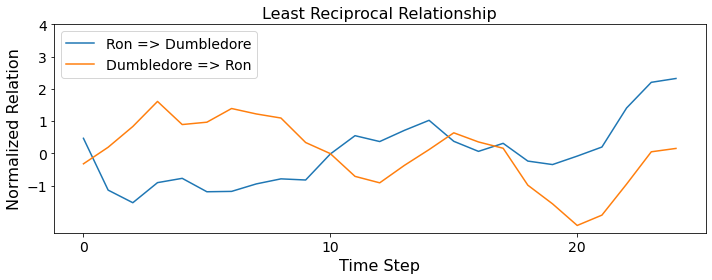

In [22]:
plt.figure(figsize=(10,4))

i1,i2 = 1,3

c1 = potential_characters[i1]
c2 = potential_characters[i2]

c1_c2_ts = normalize(inclusion_matrix[i1,i2,:])
c2_c1_ts = normalize(inclusion_matrix[i2,i1,:])
plt.plot(c1_c2_ts)
plt.plot(c2_c1_ts)

plt.xticks(np.arange(0,25,10), fontsize=14)
plt.xlabel('Time Step', fontsize=16)

plt.yticks(np.arange(-1,5), fontsize=14)
plt.ylabel('Normalized Relation', fontsize=16)

plt.legend(['%s => %s'%(c1,c2), '%s => %s'%(c2,c1)], fontsize=14, loc=2)

plt.title('Least Reciprocal Relationship', fontsize=16)
plt.tight_layout()

plt.savefig('least_rec.png')

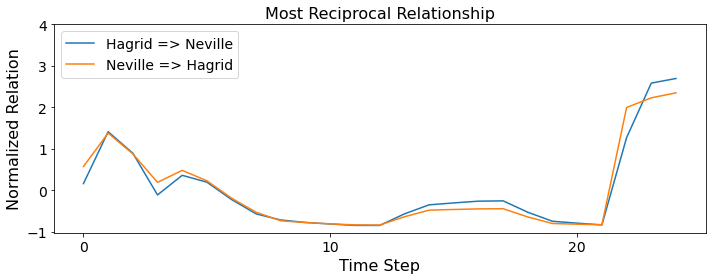

In [23]:
plt.figure(figsize=(10,4))

i1,i2 = 5, 12

c1 = potential_characters[i1]
c2 = potential_characters[i2]

c1_c2_ts = normalize(inclusion_matrix[i1,i2,:])
c2_c1_ts = normalize(inclusion_matrix[i2,i1,:])
plt.plot(c1_c2_ts)
plt.plot(c2_c1_ts)

plt.xticks(np.arange(0,25,10), fontsize=14)
plt.xlabel('Time Step', fontsize=16)

plt.yticks(np.arange(-1,5), fontsize=14)
plt.ylabel('Normalized Relation', fontsize=16)

plt.legend(['%s => %s'%(c1,c2), '%s => %s'%(c2,c1)], fontsize=14, loc=2)

plt.title('Most Reciprocal Relationship', fontsize=16)
plt.tight_layout()

plt.savefig('most_rec.png')

# Store Adjacency Matrices into CSV Files

In [24]:
for t in range(25):
    df = pd.DataFrame(inclusion_matrix[:,:,t])
    df.to_csv('AdjacencyMatrices/mtx_%s.csv'%t, index=False, header=False)

# Covariate Summaries

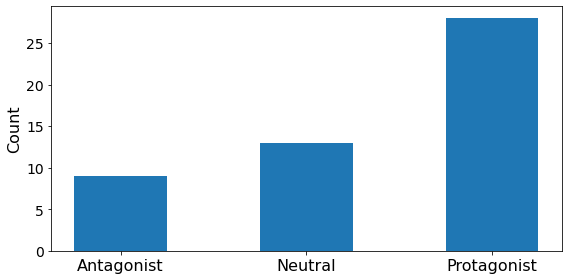

In [25]:
plt.figure(figsize=(8,4))
plt.bar([-1,0,1], [len([v for k,v in char_to_alignment.items() if v == i]) for i in [-1,0,1]], width=0.5)
plt.xticks([-1,0,1], ['Antagonist', 'Neutral', 'Protagonist'], fontsize=16)
plt.yticks(np.arange(0,30,5), fontsize=14)
plt.ylabel('Count', fontsize=16)
plt.tight_layout()
plt.savefig('count_align.png')

In [26]:
plt.figure(figsize=(35,20))
cumul_occs = {c: 0 for c in potential_characters}
for t in range(25):
    for k,v in num_occs[t].items():
            cumul_occs[k] += v
    counts = list(cumul_occs.values())
    outlier_thresh = np.mean(counts) + 2*np.std(counts)
    counts = [i for i in counts if i < outlier_thresh]
    plt.subplot(5,5,t+1)
    sns.distplot(counts, kde=True)
    plt.title('Time Step %s'%(t+1), fontsize=24)
plt.tight_layout()
plt.savefig('num_occs_over_time.png')

NameError: name 'num_occs' is not defined

<Figure size 2520x1440 with 0 Axes>

In [ ]:
plt.figure(figsize=(6,10))
cumul_occs = {c: 0 for c in potential_characters}

char_to_ser = {}

curr = 1

for c in potential_characters:
    ser = [num_occs[t][c] for t in range(25)]
    ser = np.array([sum(ser[:i+1]) for i in range(25)])
    char_to_ser[c] = ser
    if c in ['Harry', 'Sirius', 'Voldemort', 'Moody', 'Slughorn']:
        plt.subplot(5,1,curr)
        plt.plot(ser)
        plt.title(c, fontsize=16)
        plt.ylabel('Num\nOccurences', fontsize=14)
        plt.xlabel('Time Step' if c == 'Slughorn' else '', fontsize=14)
        curr += 1
plt.tight_layout()
plt.savefig('num_occ_chosen.png')

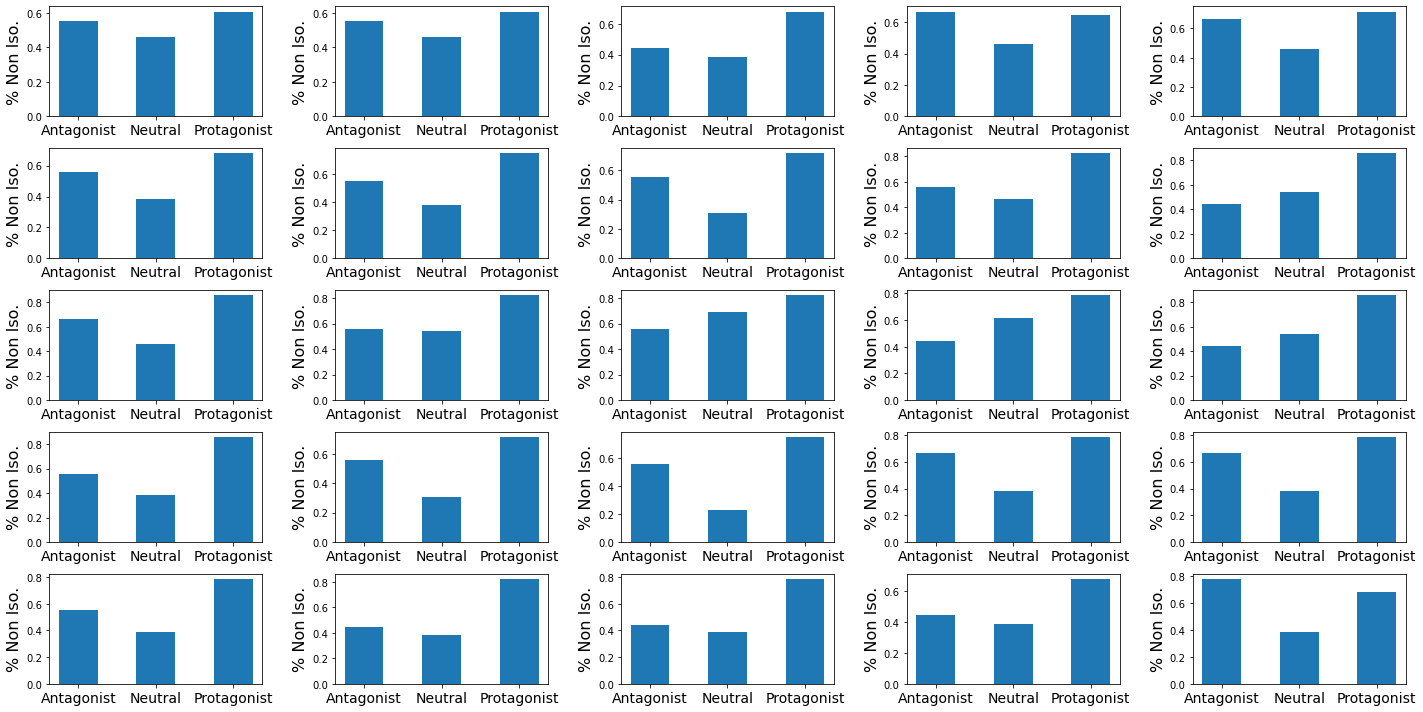

In [27]:
plt.figure(figsize=(4*5,2*5))

for t in range(25):
    nodes = np.array(G.nodes)
    M = nx.to_numpy_array(time_to_G[t])
    non_isolate_inds = (M.sum(axis=0) > 0) | (M.sum(axis=1) > 0)
    M = M[non_isolate_inds, non_isolate_inds]
    nodes = nodes[non_isolate_inds]
    
    plt.subplot(5,5,t+1)
    plt.bar([-1,0,1], [len([c for c in nodes if char_to_alignment[c] == i]) / tot_alignment[i] for i in [-1,0,1]], width=0.5)
    plt.xticks([-1,0,1], ['Antagonist', 'Neutral', 'Protagonist'], fontsize=14)
    plt.ylabel('% Non Iso.', fontsize=16)

plt.tight_layout()
plt.savefig('pct_align_time.png')

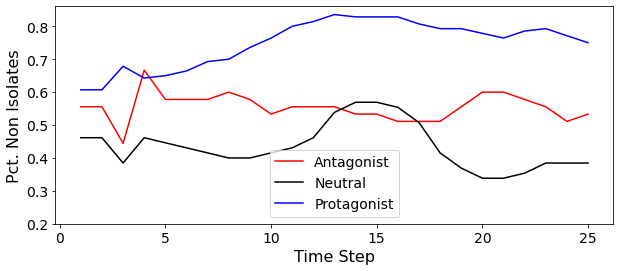

In [28]:
plt.figure(figsize=(10,4))

D = np.zeros((25,3))

for t in range(25):
    nodes = np.array(G.nodes)
    M = nx.to_numpy_array(time_to_G[t])
    non_isolate_inds = (M.sum(axis=0) > 0) | (M.sum(axis=1) > 0)
    M = M[non_isolate_inds, non_isolate_inds]
    nodes = nodes[non_isolate_inds]
    
    frac = [len([c for c in nodes if char_to_alignment[c] == i]) / tot_alignment[i] for i in [-1,0,1]]
    D[t,:] = frac
    
plt.plot(range(1,26), rolling_avg(D[:,0], k=5), color='r')
plt.plot(range(1,26), rolling_avg(D[:,1], k=5), color='k')
plt.plot(range(1,26), rolling_avg(D[:,2], k=5), color='b')

plt.legend(["Antagonist", "Neutral", "Protagonist"], fontsize=14, loc=8)
plt.xticks(np.arange(0,30,5), fontsize=14)
plt.xlabel('Time Step', fontsize=16)
plt.yticks(np.arange(0.2,0.9,0.1), fontsize=14)
plt.ylabel('Pct. Non Isolates', fontsize=16)

plt.savefig('pct_align_time_single.png')

# Community Detection

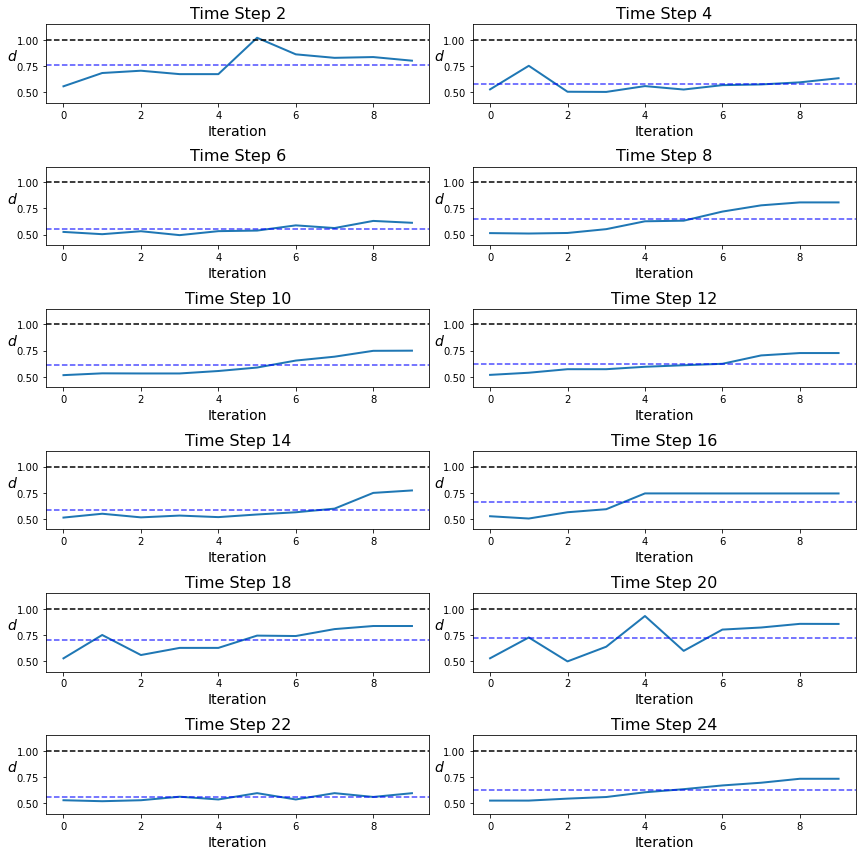

In [239]:
plt.figure(figsize=(12,12))
curr_plot = 0
for t in range(1,26):
    if t % 2 == 1:
        continue
    curr_plot += 1
    
    community_df = pd.read_csv('AdjacencyMatrices/community_result_%s.csv'%t)
    
    tot_sd = np.std(community_df.Num_Occs)

    d_vals = []

    for var in community_df.columns[2:]:
        avg_sd_within = community_df.groupby(var).std().Num_Occs.mean()
        d = avg_sd_within / tot_sd
        d_vals.append(d)
    
    plt.subplot(6,2,curr_plot)
    plt.plot(d_vals, linewidth=2)
    plt.title('Time Step %s'%t, fontsize=16)
    plt.axhline(1, color='k', linestyle='--')
    plt.axhline(np.mean(d_vals), color='blue', linestyle='--', alpha=0.7)
    plt.ylim(0.4,1.15)
    
    plt.ylabel("$d$", fontsize=14, rotation=0)
    plt.xlabel("Iteration", fontsize=14)

plt.tight_layout() 

plt.savefig('deviation_over_time.png')

In [242]:
orig_communities = community_df.V1.copy()

for t in range(1,26):
    community_df = pd.read_csv('AdjacencyMatrices/community_result_%s.csv'%t)[["Name", "V5", 'Num_Occs']]
    community_df.columns = ["Name","V_%s"%t, 'Num_Occs_%s'%t]
    if t == 1:
        overall_df = community_df.copy()
    else:
        overall_df = pd.merge(overall_df, community_df, on='Name')
        
overall_df.set_index('Name', inplace=True)
overall_df['orig_communities'] = orig_communities
    

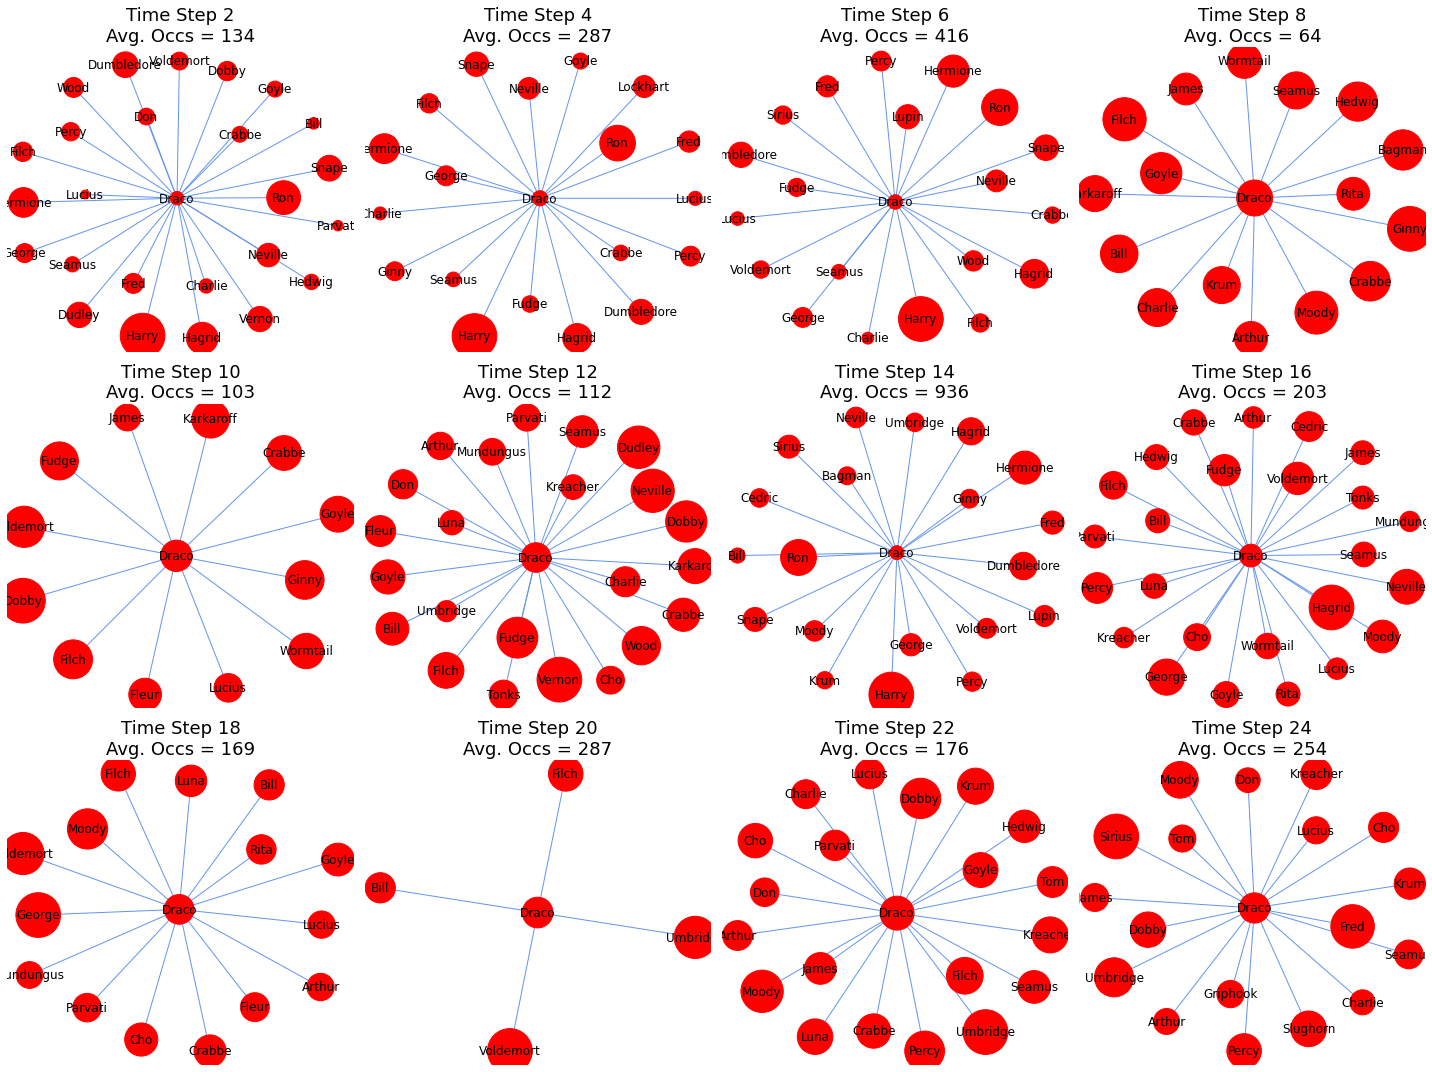

In [243]:
central_actor = "Draco"

plt.figure(figsize=(20,15))

curr_plot = 0

for t in range(1,26):
    if t%2 == 1:
        continue
    curr_plot += 1
    names = overall_df.index
    comms = overall_df["V_%s"%t]
    occs = overall_df['Num_Occs_%s'%t]
    
    central_idx = np.where(names == central_actor)[0][0]
    
    central_com = comms[central_idx]
    central_com_members = names[(comms == central_com)]
    central_com_occs = occs[(comms == central_com)]
    avg_occs = int(np.mean(central_com_occs))
    
    central_com_occs = 2000*np.sqrt((central_com_occs / central_com_occs.max()))
    
    central_idx = np.where(central_com_members == central_actor)[0][0]
    num_mems = len(central_com_members)
    
    A = np.zeros((num_mems,num_mems))
    A[central_idx] = 1
    A[central_idx,central_idx] = 0
    
    plt.subplot(3,4,curr_plot)
    G = nx.from_numpy_matrix(A, create_using=nx.Graph)
    G = nx.relabel_nodes(G, {i:p for i,p in enumerate(central_com_members)})
    nx.draw(G, with_labels=True, node_color='r', edge_color='cornflowerblue', node_size=central_com_occs, pos=nx.fruchterman_reingold_layout(G))
    plt.title('Time Step %s\nAvg. Occs = %s'%(t,avg_occs), fontsize=18)

plt.tight_layout()
plt.savefig('draco_center.png')

In [244]:
def get_mode(s):
    d = {}
    for i in s:
        if i in d:
            d[i]+=1
        else:
            d[i]=1
    return sorted(d.items(), key=lambda x: -x[1])[0][0]

In [245]:
comm_mtxs = np.zeros((50,50,25))

for t in range(1,26):
    
    comms = dict(zip(overall_df.index, overall_df['V_%s'%t]))
    for i1,c1 in enumerate(overall_df.index):
        for i2,c2 in enumerate(overall_df.index):
            if comms[c1] == comms[c2]:
                comm_mtxs[i1,i2,t-1] = 1
    

In [246]:
orig_comms = dict(zip(overall_df.index, overall_df.orig_communities))
orig_mtx = np.zeros((50,50))

for i1,c1 in enumerate(overall_df.index):
    for i2,c2 in enumerate(overall_df.index):
        if orig_comms[c1] == orig_comms[c2]:
            orig_mtx[i1,i2] = 1

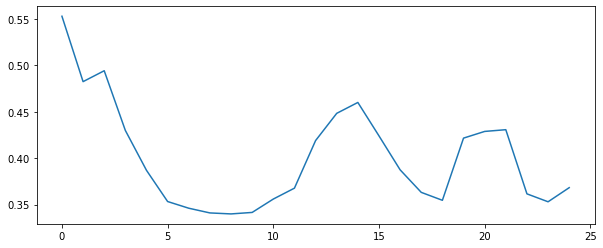

In [251]:
diffs = []
for t in range(25):
    comm_mtx_diffs = np.mean((comm_mtxs[:,:,t] - orig_mtx) != 0)
    diffs.append(comm_mtx_diffs)
plt.figure(figsize=(10,4))
plt.plot(rolling_avg(diffs,3))